# Preparing data

After collecting data, this notebook shows how to prepare data for using in a machine learning model to be trained.

In [1]:
import pickle
import pandas as pd

We saw in [collecting_data.ipynb]() that raw data is a json, or, in other words, a key: value dictionary of the web. From it, the following variables are picked to be collected.

In [2]:
chosen_user_vars = ['screen_name']
chosen_vars = ['text', 'favorite_count', 'lang', 'created_at']
# retweet_count crashes unfortunately :/

In [3]:
data = []
for i in range(5):
    with open('data/favs_%d.pkl' % i, 'rb') as handle:
        for tweet in pickle.load(handle):
            row = []
            row = [tweet[var] for var in chosen_vars]
            row.insert(0, tweet['user']['screen_name'])
            data.append(row)

Now that we have picked the data we wanted from the json's, it is time to wrap it into a pandas dataframe for some magic.

In [4]:
variables = chosen_user_vars + chosen_vars
df = pd.DataFrame(data, columns=variables)
df.head()

,screen_name,text,favorite_count,lang,created_at
0,ThePracticalDev,Steps to better code\n{ author: @isaacandsuch ...,62,en,Sat Sep 30 08:02:01 +0000 2017
1,d_vf,I just published “Understanding your energy bi...,1,en,Fri Sep 29 09:14:42 +0000 2017
2,sehurlburt,Yes I am making sure adequate cat photo benchm...,70,en,Fri Sep 29 04:26:45 +0000 2017
3,ThePracticalDev,Coding = thinking in several dimensions\n{ aut...,61,en,Thu Sep 28 16:28:28 +0000 2017
4,azool_97,@pewdiepie Kimi no na wa used heavily japanese...,142,en,Thu Sep 28 08:21:39 +0000 2017


## Indexing by date-time

It could be quite interesting to turn this to a time series data! The column `created_at` actually refers to when I liked a tweet. Let's treat that variable and let it index our data.

In [5]:
datetime_index = pd.to_datetime(df['created_at']).copy() # copy, because reference is deleted next
df = df.set_index(datetime_index).drop('created_at', axis=1) # set index and drop redundant variable
df.index.names = ['date_time'] # rename index
df.head()

,screen_name,text,favorite_count,lang
date_time,,,,
2017-09-30 08:02:01,ThePracticalDev,Steps to better code\n{ author: @isaacandsuch ...,62,en
2017-09-29 09:14:42,d_vf,I just published “Understanding your energy bi...,1,en
2017-09-29 04:26:45,sehurlburt,Yes I am making sure adequate cat photo benchm...,70,en
2017-09-28 16:28:28,ThePracticalDev,Coding = thinking in several dimensions\n{ aut...,61,en
2017-09-28 08:21:39,azool_97,@pewdiepie Kimi no na wa used heavily japanese...,142,en


In [6]:
df.describe() # will describe the only numerical variable present in the dataset

,favorite_count
count,844.000000
mean,5546.742891
std,37044.754889
min,1.000000
25%,9.000000
50%,49.500000
75%,357.250000
max,742777.000000


In [7]:
df.plot()

So, over time, I've been increasingly liking tweets that many other people also like, at least visually.

## A note on languages and locales

en     764
pt      31
und     24
es      14
ja       6
tl       2
fr       2
ro       1
Name: lang, dtype: int64


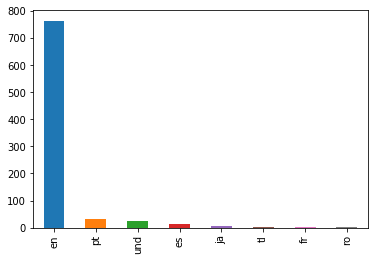

In [8]:
print(df['lang'].value_counts())
df['lang'].value_counts().plot(kind='bar')

Apparently, I liked tweets from multiple languages! This is a surprise for me because I thought I'd have only `pt` and `en`. I suppose I enjoy artwork from japan, hence the presence of `ja`. These japanese tweets may be an issue later on given that they should be written in japanese characters. 私は今何をするのですか？ I could in theory delete all the tweets which are not in `en`... Like, how do I do a bag-of-words analysis? I guess I could learn what japanese words I am most attracted to without consciously knowing it...

In [9]:
other_langs = df['lang'].value_counts()[1:].sum()
percentage = round(other_langs / float(df.shape[0]), 2)
print('# tweets from other langs:', other_langs)
print('fraction of tweets from other langs:', percentage)

# tweets from other langs: 80
fraction of tweets from other langs: 0.09


This means, that if I were to exclude all other langs, I'd be keeping 91% of the data. I do think, however, that this measure is not exact, as `lang` may be a param that defaults to the users device locale, and may not represent the languages they tweet in. We can take a look at the text of these `ja`panese tweets.

In [10]:
japanese_tweets = df[df['lang'] == 'ja']['text']
japanese_tweets

date_time
2017-08-18 14:20:56                       日が沈むまで https://t.co/MNVFE5G9ly
2017-01-01 22:13:34               後ろに飛んで消えて欲しかった https://t.co/19gzFGPf4A
2016-12-27 15:38:36        和装ピュラさん！\n「御免」\n#RWBY https://t.co/lpL8S6Pmga
2016-11-05 15:05:49    ジョーンがピュラの残したビデオで練習しているその頃、ピュラは… https://t.co/T...
2016-11-05 05:10:15    そろそろ忙しいのも落ち着いてきたのでぼちぼちrwby併せ計画していきたい😆✨呼ばれたら即いく...
2016-10-28 05:14:15    @mojojoj27827860 猫を被る(Wear a Cat)＝shed crocodi...
Name: text, dtype: object

And the very last tweet from (I suppose) a japanese user shows some english words. If this presents an issue, I will some time later down the pipeline (see what I did here) restrict the dataset to `en`, at the cost of excluding tweets that may represent my interests. Anyways, I do consider that `en` tweets contain enough data about my nerdy / professional interests... So, yes, I am sacrificing the other tweets.

In [11]:
df = df[df['lang'] == 'en'].drop('lang', axis=1)
df.head()

,screen_name,text,favorite_count
date_time,,,
2017-09-30 08:02:01,ThePracticalDev,Steps to better code\n{ author: @isaacandsuch ...,62
2017-09-29 09:14:42,d_vf,I just published “Understanding your energy bi...,1
2017-09-29 04:26:45,sehurlburt,Yes I am making sure adequate cat photo benchm...,70
2017-09-28 16:28:28,ThePracticalDev,Coding = thinking in several dimensions\n{ aut...,61
2017-09-28 08:21:39,azool_97,@pewdiepie Kimi no na wa used heavily japanese...,142


In [12]:
df['screen_name'].value_counts()[:6]

sehurlburt         56
ThePracticalDev    37
TheHappieCat       24
sirajraval         19
slashML            15
DJ_Link            13
Name: screen_name, dtype: int64

## Cleaning the tweets
- hastags and referring people are kept as real words (characters `#` and `@`)
- punctuation removed, stopwords removed as well (and portuguese and english have different stopwords!)
- urls are removed

In [13]:
from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

### A note on stopwords
One of the following steps is to remove "stop" words, words that are often auxiliary in constructing meaning, but lack content. You may itch to know what these words can be.

In [14]:
print(stopwords.words('english')[:10])
print(stopwords.words('portuguese')[:10])
print(stopwords.words('german')[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para']
['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an']


### Text-cleaning function definition

In [15]:
def clean_tweet(tweet, join=True):
    # word tokenizer
    tokenizer = TweetTokenizer(strip_handles=False)
    tokens = tokenizer.tokenize(tweet)
    # lower case
    tokens = [word.lower() for word in tokens]
    # remove stop words
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # get only stems of words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(t) for t in tokens]
    # remove non-alphabetic tokens, such as punctuation, urls.
    # a couple of 'or's are there to include further content such as @rustlang or #haskell
    tokens = [token for token in tokens if token.isalpha() or '#' in token or '@' in token]
    # however the hash # may be part of a url instead...
    # return
    if join:
        return ' '.join(tokens)
    return tokens

And here are a couple of examples of this cleaning function

In [16]:
def print_cleaning_example(instance_index):    
    print('-----------------------')
    print(df['text'][instance_index])
    print('::>', clean_tweet(df['text'][instance_index]))
print_cleaning_example(0)
print_cleaning_example(24)
print_cleaning_example(23)

-----------------------
Steps to better code
{ author: @isaacandsuch }
https://t.co/lHL37fyC8e
::> step better code author @isaacandsuch
-----------------------
Do you want to come to the book fair and flirt awkwardly with me?
::> want come book fair flirt awkwardli
-----------------------
We're are havin' a ball with @haskell_lang #lambdapt #meetup https://t.co/h4wWYx7PBn
::> havin ball @haskell_lang #lambdapt #meetup


Did I mention I like coding? Anyways, the dataframe is now rewritten as:

In [17]:
df['text'] = df['text'].apply(clean_tweet)

In [18]:
df.head()

,screen_name,text,favorite_count
date_time,,,
2017-09-30 08:02:01,ThePracticalDev,step better code author @isaacandsuch,62
2017-09-29 09:14:42,d_vf,publish understand energi bill,1
2017-09-29 04:26:45,sehurlburt,ye make sure adequ cat photo benchmark talk cu...,70
2017-09-28 16:28:28,ThePracticalDev,code think sever dimens author @andreaskling,61
2017-09-28 08:21:39,azool_97,@pewdiepi kimi na wa use heavili japanes idea ...,142


In [19]:
# we're at a good stage to store the dataset
with open('faved_tweets.df', 'wb') as handle:
    pickle.dump(df, handle)